# Introduction


In the project this week, we will focus on model performance monitoring for the news classification model that we deployed in week 3 (and developed in weeks 1 and 2)

1. We will download and parse the training dataset, logs from prediction service that record inference traffic and annotations (ground truth labels for the inference traffic)
2. We will set up basic monitoring for system health (traffic volume, latency, SLA violations)
3. We will compute data and label drift for the inference traffic using a few different techniques (Chi-square statistic, KS-statistic, classifier-based drift detection)
4. We will understand model performance as a function of time for the inference traffic, and any ties we can derive to detected drift
5. [optional] We will experiment with outlier detection techniques and understand the impact of outliers on model performance.



## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [1]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install umap-learn
!pip install plotly
!pip install alibi_detect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 41.8 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82832 sha256=6f747d05892c637e08cff790bb71cc25c312e1366a58782925606f858b472e45
  Stored in directory: /Users/sjabbireddy/Library/Caches/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55639 sha256=9c1a52a166d9b5e68a973163beb7cffe1bd10312c2c4b55d2cb4b82c9047e1f3
  Stored in directory: /Users/sjabbireddy/Library/Caches/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Succ

In [2]:
import json
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import date, timedelta
import matplotlib.pyplot as plt
import umap
from sklearn import metrics as sklearn_metrics
import plotly.graph_objects as go


/Users/sjabbireddy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sjabbireddy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/sjabbireddy/.pyenv/versions/3.10.0/lib/python3.10

In [3]:
# Global Constants

LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

DATA_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project4/agnews_logs.zip'

LOG_DATE_START = date(2022, 7, 11)   # '2022-07-11'
LOG_DATE_END = date(2022, 7, 24)   # '2022-07-24'

## Step 2: Download and Load Dataset

In weeks 1 and 2, we worked with a modified version of the [AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) dataset - a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. This news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626).

In week 3, we started logging model inputs and predictions for the web application that we created for the trained news classifier.

The dataset for this week's project is a combination of the two. We will work with the following files in the downloaded data:
1. `training.json` -- this is the training data on which the classification model was trained. This will act as the reference dataset when we want to compute things like drift and outliers. Each row in this file is a training data point.
2. `logs.json` -  this is a collection of logged outputs from our online service (the inference traffic). Each row in this file is a timestamped request, and contains the input request (text description, embedding, url etc) as well as model predictions. This will act as the target dataset when we want to compute things like drift and outliers. **The logs span a two week period from 2022/07/11 to 2022/07/24.**
3. `annotations.json` - this is the set of ground truth labels for requests received by our online prediction service. Imagine we have a team of human annotators that label a fraction of our inference stream (with some delay). Eventually these ground truth labels are logged and will be helpful for us to monitor online model performance, and also is a good source of future training data for the model.

Sample row in the training dataset:
```
{
   "id": 86273,
   "source": "Voice of America",
   "title": "Capsule from Genesis Space Probe Crashes in Utah Desert",
   "url": "http://www.sciencedaily.com/releases/2004/09/040908090621.htm",
   "rank": "5",
   "description": "A capsule carrying solar material from the Genesis space probe has made a crash landing at a US Air Force training facility in the US state of Utah.",
   "embedding": [...],
   "label": "Sci/Tech"
}
```

Sample row in the logs file:

```
{
    "id": 69265,
    "timestamp": "2022-07-11 00:00:00",
    "host_id": "host_4",
    "latency_ms": 169.676,
    "request": {
        "id": 69265,
        "source": null,
        "title": "Google May Face Another Lawsuit",
        "url": "http://www.pcworld.com/news/article/0,aid,117686,00.asp",
        "rank": "5",
        "description": "A federal judge in Virginia has ruled that a trademark infringement suit filed by the Government Employees Insurance Co. (GEICO) against Internet search giants Google and Overture Services can proceed.",
        "embedding": [...]
    },
    "pred_label": "Business",
    "pred_score": {
        "Business": 0.39581484916169474,
        "Entertainment": 0.19195937955028541,
        "Health": 0.02007952252798203,
        "Music Feeds": 0.0005983183076385058,
        "Sci/Tech": 0.3849374113779283,
        "Software and Developement": 0.001389120851963045,
        "Sports": 0.004566606342231832,
        "Toons": 0.0006547918802761208
    }
}
```
Sample row in the annotations file (rows in here should be joined to the correct request in `logs.json` using the "id" field):
```
{
    "id": 69265,
    "label": "Sci/Tech"
}
```

In [4]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"


def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json
    """
    http_response = urlopen(DATA_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)


# Expensive operation so we should just do this once
download_dataset()


In [6]:
"""
[TO BE IMPLEMENTED]

1. Load the training dataset, inference logs and annotations from the downloaded data
2. Join the rows from `logs.json` and `annotations.json`.
   Rows in these files should be matched using the "id" field - this is unique string assigned to each incoming request
"""

training = []

# The logs span a two week period from 2022/07/11 to 2022/07/24.
logs = []

true_labels = []


with open('data/training.json', 'r') as f:
    for line in f:
        training.append(json.loads(line))

with open('data/logs.json', 'r') as f:
    for line in f:
        logs.append(json.loads(line))

with open('data/annotations.json', 'r') as f:
    for line in f:
        true_labels.append(json.loads(line))

training_df = pd.DataFrame(training)
logs_df = pd.DataFrame(logs)
true_labels_df = pd.DataFrame(true_labels)

df_logs_true_labels = pd.DataFrame.copy(true_labels_df).merge(logs_df, on='id')

print(len(training_df), len(logs_df), len(true_labels_df), len(df_logs_true_labels))

25000 87213 87213 87213


In [7]:
logs_df.head()

,id,timestamp,host_id,latency_ms,request,pred_label,pred_score
0,69265,2022-07-11 00:00:00,host_4,169.676,"{'id': 69265, 'source': None, 'title': 'Google...",Business,"{'Business': 0.39581484916169474, 'Entertainme..."
1,444122,2022-07-11 00:00:09,host_3,183.468,"{'id': 444122, 'source': 'Reuters', 'title': '...",Health,"{'Business': 0.03158270082143275, 'Entertainme..."
2,330629,2022-07-11 00:00:17,host_1,176.948,"{'id': 330629, 'source': None, 'title': 'All-S...",Sports,"{'Business': 0.004083249952881476, 'Entertainm..."
3,95664,2022-07-11 00:00:26,host_2,123.724,"{'id': 95664, 'source': 'Channel News Asia', '...",Entertainment,"{'Business': 0.011457933535418576, 'Entertainm..."
4,482461,2022-07-11 00:01:09,host_3,149.040,"{'id': 482461, 'source': None, 'title': 'Euron...",Business,"{'Business': 0.7837987635037846, 'Entertainmen..."


## Step 3: System Health & Metrics

As we saw in the lecture, software system failures and downtimes are remarkably common even in ML systems. In an [analysis](https://www.youtube.com/watch?v=hBMHohkRgAA) conducted by Daniel Papasian and Todd Underwood (both ML engineers at Google), they looked at large ML pipeline failures at Google and found out that in 60 out of the 96 cases, the cause for failure was not directly related to the ML model.

For such cases, tracking system health can be a good first step to ensure properties such as whether the deployed model is available online, is its latency within acceptable SLAs, are the system resources (such as CPU and memory usage) within bounds etc.


In [9]:
df_logs_true_labels['date'] = pd.to_datetime(df_logs_true_labels['timestamp']).dt.normalize()
request_volume = df_logs_true_labels.groupby(['host_id', 'date'])['request'].count()
request_volume

host_id  date      
host_1   2022-07-11    1529
         2022-07-12    1496
         2022-07-13    1508
         2022-07-14    1502
         2022-07-15    1504
                       ... 
host_5   2022-07-20    1459
         2022-07-21    1391
         2022-07-22    1392
         2022-07-23    1381
         2022-07-24     879
Name: request, Length: 63, dtype: int64

In [10]:
"""
[TO BE IMPLEMENTED]

Each row in the logs.json file has an associated timestamp of the format YYYY-MM-DD HH:MM:SS.
The logs span a two week period from 2022/07/11 to 2022/07/24.
We will use the timestamp to group requests by date, and track a few system metrics of interest:

1. Volume: Compute the daily volume of requests received by our service, grouped by host id.
2. Latency: Compute the mean, median, P90, P95 latency of requests received by our service, grouped by host id
3. Plot each of these as a line chart, with date on the X-axis and the computed metric on the Y-axis.
You can plot the metric for each host id in the same line chart (with different colors for each host).

Do you notice anything strange with one of the hosts? :)

"""
df_logs_true_labels['date'] = pd.to_datetime(df_logs_true_labels['timestamp']).dt.normalize()

#Volume: Compute the daily volume of requests received by our service, grouped by host id.
request_volume = df_logs_true_labels.groupby(['host_id', 'date'])['request'].count()

#Latency: Compute the mean, median, P90, P95 latency of requests received by our service, grouped by host id
latency_requests_mean = df_logs_true_labels.groupby(['host_id', 'date'])['latency_ms'].mean()
latency_requests_median = df_logs_true_labels.groupby(['host_id', 'date'])['latency_ms'].median()
latency_requests_p90 = df_logs_true_labels.groupby(['host_id', 'date'])['latency_ms'].quantile(q=0.9)
latency_requests_p95 = df_logs_true_labels.groupby(['host_id', 'date'])['latency_ms'].quantile(q=0.95)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/lt/lwh95s7519lckh62dtd3s00m0000gp/T/ipykernel_13706/238784202.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)


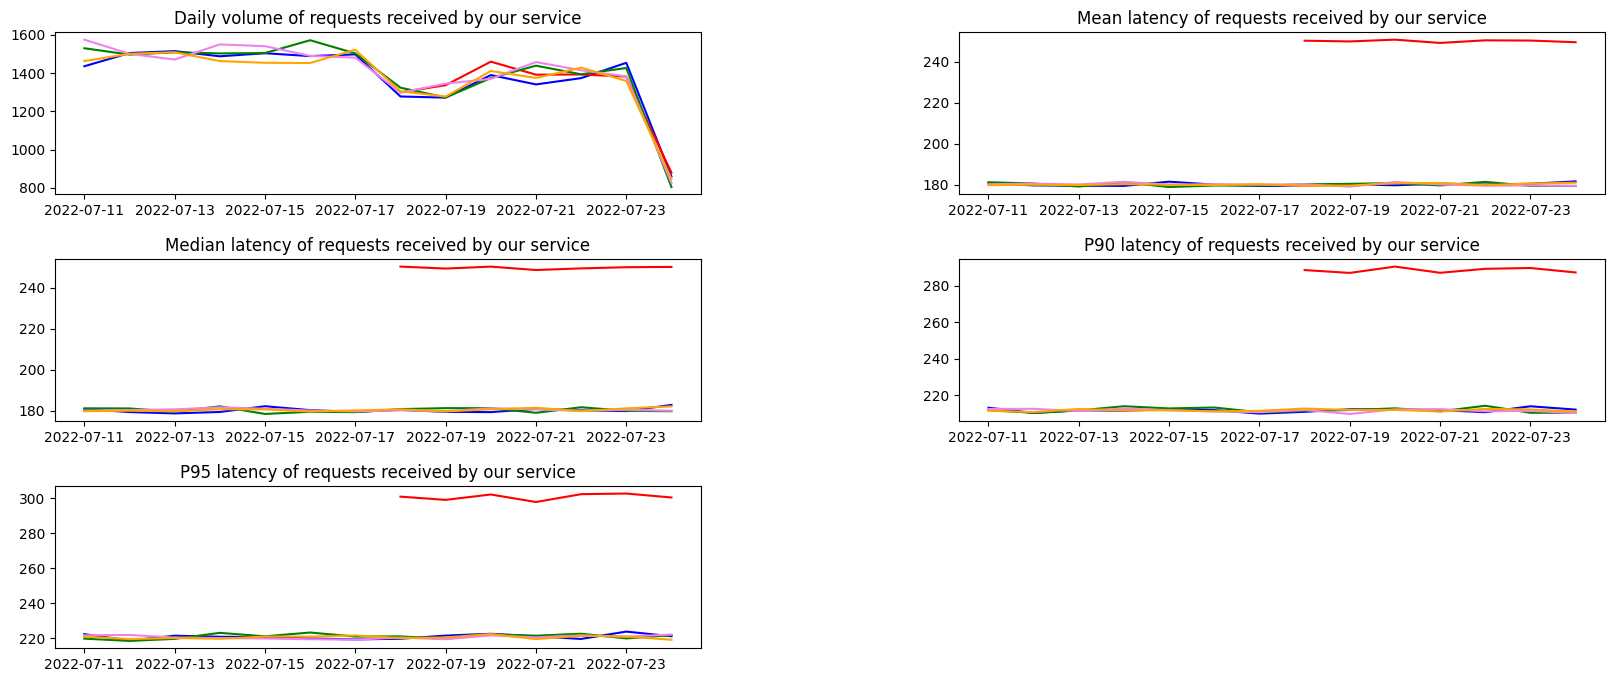

In [16]:
fig = plt.figure()
fig.set_size_inches(20, 8)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#for i in range(1,5):
#  ax = fig.add_subplot(2, 3, i)
#  plt.plot(daily_requests_per_host["host_1"], color="blue")

hosts = set(df_logs_true_labels["host_id"].values.tolist())
colors = ["blue", "red", "green", "violet", "orange"]
plt.legend(fontsize="8")
plt.subplot(3, 2, 1)

plt.title("Daily volume of requests received by our service")
for idx, host in enumerate(hosts):
  plt.plot(request_volume[host], color=colors[idx], label=host)


plt.subplot(3, 2, 2)
plt.title("Mean latency of requests received by our service")
for idx, host in enumerate(hosts):
  plt.plot(latency_requests_mean[host], colors[idx], label=host)


plt.subplot(3, 2, 3)
plt.title("Median latency of requests received by our service")
for idx, host in enumerate(hosts):
  plt.plot(latency_requests_median[host], color=colors[idx], label=host)


plt.subplot(3, 2, 4)
plt.title("P90 latency of requests received by our service")
for idx, host in enumerate(hosts):
  plt.plot(latency_requests_p90[host], color=colors[idx], label=host)


plt.subplot(3, 2, 5)
plt.title("P95 latency of requests received by our service")
for idx, host in enumerate(hosts):
  plt.plot(latency_requests_p95[host], color=colors[idx], label=host)



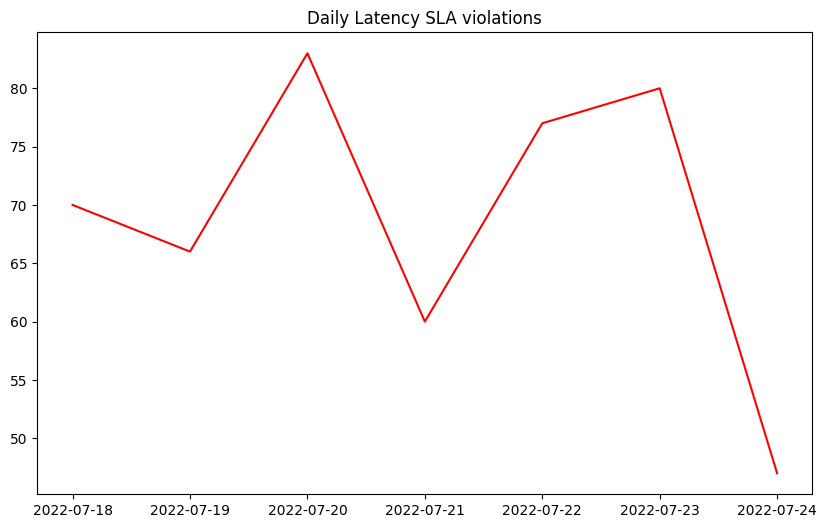

In [19]:
"""
[TO BE IMPLEMENTED]

Let us say that we have a maximum latency SLA of 300 milliseconds i.e.
if the prediction service took more than 300 ms to answer the request, the downstream experience is degraded for users.

1. Compute the aggregate daily volume of latency SLA violations (i.e. number of requests that have a latency >= maximum allowed latency) grouped by each host id
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.
"""

daily_latency_sla_violations = df_logs_true_labels[df_logs_true_labels['latency_ms'] >= 300].groupby(["host_id", "date"])["request"].count()


plt.figure(figsize=(10,6))
plt.title("Daily Latency SLA violations")
plt.plot(daily_latency_sla_violations["host_5"], color="red", label="host_5", )


## Step 4: Model inputs and outputs

In supervised machine learning settings, we assume that the training dataset D = {X, y} is composed of input/label tuples {Xi, yi} that are independently drawn from some underlying joint distribution ℙ(X, y) such that ℙ(X, y) = ℙ(y|X)ℙ(𝐗)

ℙ(y|X) is the relationship we are trying to learn during the model training step, which can then be used to generate accurate predictions for unseen samples. We make two assumptions here:
1. The unseen samples that the model will be used to make predictions on, comes from the same underlying distribution ℙ(X, y).
2. This distribution ℙ(X, y) is stationary and does not change with time.

In practice, as we saw in the lecture, this assumption does not hold in most cases. Can we track and quantify this change over time though?

### Step 4[part 1]: Input drift (hypothesis testing)

Hypothesis testing is a principled approach to evaluating drift. It’s a test to determine whether the difference between two populations (two sets of data) is statistically significant. If the difference is statistically significant, then the probability that the difference is a random fluctuation due to sampling variability is very low, and therefore, the difference is caused by the fact that these two populations come from two distinct distributions.

1. Design a test statistic (or a distance metric) that is computed on samples collected form the two distributions - in our case, the reference and target distributions (i.e. data points from the inference and reference datasets)
2. The test statistic is expected to be small if the null hypothesis is true (i.e. Z and Zref are drawn from the same distribution), and large if the alternative hypothesis (i.e. Z and Zref are drawn from different distributions) is true.
3. From the test statistic, we compute a p-value: When p-value ≤ threshold, results from the test are said to be statistically significant, and the null hypothesis P(z) = Pref(z) is rejected.


In [52]:
"""
[TO BE IMPLEMENTED]

News source (e.g. New York Times, Reuters, BBC etc) is an important piece of metadata about the incoming requests.
Different news sources cover different topics, and any shift in the distribution/prevalence of news sources
can be an important early signal to suggest that online traffic patterns might be changing.

1. Both, the training dataset and infernce logs contains the news source metadata.
2. Using the training dataset as the reference, quantify the drift in news sources for incoming requests.
   You will compute drift for each day, using the inference logs from that day (i.e. "target") and comparing it to the training dataset (i.e. "reference")
3. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

Which metric should you use to measure drift though? Chi-squared statistic is commonly used to measure drift for categorical features as we discussed.

Refer to:
1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
2) https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/chisquaredrift.html (in turn uses scipy under the hood)

These implementations will return the distance, and the p-value of the null hypothesis as part of the response
You want to plot the p-value in the line chart.

MAKE SURE YOU DEAL WITH MISSING/NULL/NONE VALUES IN THE TRAINING AND INFERENCE DATA IN A CONSISTENT WAY
"""

news_sources_ref = [row['source'] for row in training]
delta = LOG_DATE_END - LOG_DATE_START


def news_source_target_todate(date):
   request_df = df_logs_true_labels[df_logs_true_labels["date"] == pd.to_datetime(curr_date)]["request"]

   testsource_target = []
   [testsource_target.append(request["source"]) for request in request_df]

   testsource_target = np.array(pd.Series(testsource_target).dropna().tolist())
   
   return testsource_target


In [54]:
from alibi_detect.cd import ChiSquareDrift

# news_sources_target = []
news_sources_drift = []
testdates = []

# remove source "OTHER/UNKNOWN" from news_sources_ref
news_sources_ref = list(filter(lambda l: l != "OTHER/UNKNOWN", news_sources_ref))

for d in range(delta.days + 1):
   curr_date = LOG_DATE_START + timedelta(days=d)

   # Step 1: collect all requests from logs.json with timestamp on the curr_date
   # this is currently a dummy empty list
   news_sources_target = news_source_target_todate(curr_date)

   # Step 2: compute the drift between `news_sources_target` and `news_sources_ref` using Chi squared statistic
   # you can use either the scipy.stats.chisquare or the implementation in alibi-detect as shared in the references above
   cd = ChiSquareDrift(np.array(news_sources_ref), p_val=0.05)
   preds = cd.predict(news_sources_target, drift_type='batch', return_p_val=True, return_distance=True)
   print(f'{curr_date}: {preds}')

   # Step 3: store the pvalue in `news_sources_drift`
   testdates.append(curr_date)
   news_sources_drift.append(preds["data"]["p_val"])

2022-07-11: {'data': {'is_drift': 0, 'distance': array([38.250187], dtype=float32), 'p_val': array([0.50389075], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'ChiSquareDrift', 'online': False, 'data_type': None, 'version': '0.11.3', 'detector_type': 'drift'}}
2022-07-12: {'data': {'is_drift': 0, 'distance': array([44.815376], dtype=float32), 'p_val': array([0.24102826], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'ChiSquareDrift', 'online': False, 'data_type': None, 'version': '0.11.3', 'detector_type': 'drift'}}
2022-07-13: {'data': {'is_drift': 0, 'distance': array([35.8906], dtype=float32), 'p_val': array([0.61248446], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'ChiSquareDrift', 'online': False, 'data_type': None, 'version': '0.11.3', 'detector_type': 'drift'}}
2022-07-14: {'data': {'is_drift': 0, 'distance': array([43.882244], dtype=float32), 'p_val': array([0.27222097], dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'ChiSquareDrift', 'online': Fals

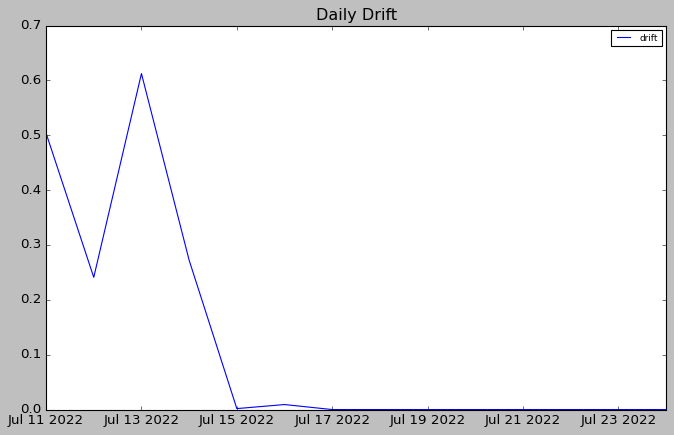

In [62]:
# Step 4:  Plot the `news_sources_drift` as a line chart, with date on the X-axis and the computed metric on the Y-axis.
plt.style.use("classic")

fig = plt.figure()
fig.set_size_inches(10, 6)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.title("Daily Drift")
plt.plot(testdates, news_sources_drift, color="blue", label="drift")
plt.legend(fontsize="8")

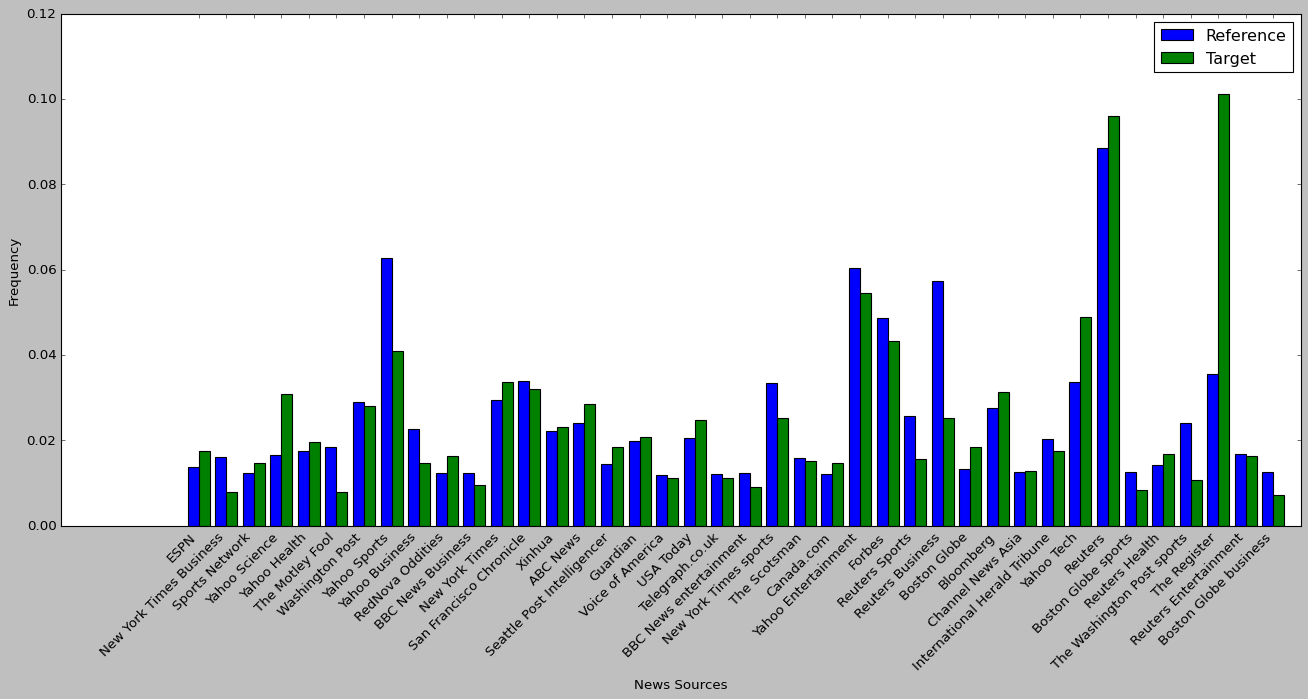

In [70]:
"""
[TO BE IMPLEMENTED]

It seems like there is some divergence in the distributions of the news sources feature between the reference and target set on some days.
Let's visualize this:

Let's take a look at the last day of inference traffic (you might observe p-value << 0.05 in the cell above for this day).
Plot a bar chart with the news sources on the X-axis, and normalized frequences in the reference and target datasets on the Y-axis

MAKE SURE TO NORMALIZE THE FREQUENCIES SINCE THE RAW NUMBER OF OBSERVATIONS IN BOTH LISTS WILL NOT BE THE SAME

"""

from typing import List

fig = plt.figure()
fig.set_size_inches(20, 8)

def plot_chart(news_sources: List, freq_reference: List, freq_target: List):
    X_axis = np.arange(len(news_sources))
    plt.bar(X_axis - 0.2, freq_reference, 0.4, label='Reference')
    plt.bar(X_axis + 0.2, freq_target, 0.4, label='Target')

    plt.xticks(X_axis, news_sources)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("News Sources")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


news_sources_ref_df = pd.Series(news_sources_ref)
news_sources_ref_df = news_sources_ref_df.value_counts(normalize=True)

news_sources_target = news_source_target_todate(LOG_DATE_END)
news_sources_target_df = pd.Series(news_sources_target)
news_sources_target_df = news_sources_target_df.value_counts(normalize=True)

news_source = []
freq_reference = []
freq_target = []

for source in set(news_sources_ref):
    news_source.append(source)
    freq_reference.append(news_sources_ref_df[source])
    freq_target.append(news_sources_target_df[source])


# You can plot both the bar charts together by calling the `plot_chart` function
plot_chart(
    news_sources=news_source,
    freq_reference=freq_reference,
    freq_target=freq_target,
)



### Step 4[part 2]: Input drift (Classifier based)

The previous approach of treating drift detection as a two-sample hypothesis test is based on designing the correct test statistic. Oftentimes it can be hard to choose the correct statistic, and most test statistics are prone to false positives especially for multivate high dimensional data.

What if we instead treat this as a classification problem? Can we train a classifier to predict which of the two distributions (reference or the target distribution) a given data point came from? The basic intuition is that if a classifier can learn to discriminate between the two distributions significantly better than random, then drift must have occurred.

The classifier-based drift detector tries to correctly distinguish instances from the reference dataset vs. the target dataset by training a classifier. It is possible to consume outputs of the classifier in a few different ways.

1. We can binarize the classifier prediction score based on a decision threshold, and apply a binomial test on the binarized predictions of the reference vs. the target data.
2. We can use the classifier prediction score directly and compare the different in score distributions for the reference and target datasets.



In [77]:
"""
[TO BE IMPLEMENTED]

Embeddings represent an encoding of the semantic content of the inputs to the model, and also the feature space on
top of which we train the classifier. Any shift in the space of embeddings can be an important signal to suggest
that online traffic patterns might be changing which can impact downstream model performance

1. Both, the training dataset and infernce logs contain embedding representations of the news article description.
2. Using the training dataset as the reference, quantify the drift in embeddings for incoming requests.
   You will compute drift for each day, using the inference logs from that day (i.e. "target") and comparing it to the training dataset (i.e. "reference")
3. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

We will implement classifer-based drift detection for embeddings. You are free to choose the architecture of the classifier,
but feel free to go with something simple (e.g. logistic regression, or a neural network with one hidden layer).

Remember, this is a binary classifier that tries to predict whether a given data point belongs to the reference or the target distribution.

Also, remember that a new instance of the classifier will be trained for each (referce, target) pair i.e. for each day

Refer to:
1) https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/classifierdrift.html
2) https://openreview.net/forum?id=SJkXfE5xx

These implementations will return the distance, and the p-value of the null hypothesis as part of the response
You want to plot the p-value in the line chart.
"""

from sklearn.linear_model import LogisticRegression
from alibi_detect.cd import ClassifierDrift

def get_embedding_target_todate(date):
   df = df_logs_true_labels[df_logs_true_labels["date"] == pd.to_datetime(curr_date)]["request"]
   
   embeddings = []
   [embeddings.append(request["embedding"]) for request in df]

   return embeddings


embeddings_ref = [row['embedding'] for row in training]

delta = LOG_DATE_END - LOG_DATE_START
embeddings_drift = []
cls_testdates = []

for d in range(delta.days + 1):
   curr_date = LOG_DATE_START + timedelta(days=d)
   print(curr_date)

   # Step 1: collect all requests from logs.json with timestamp on the curr_date
   # this is currently a dummy empty list
   embeddings_target = get_embedding_target_todate(curr_date)

   # Step 2: compute the drift between `embeddings_target` and `embeddings_ref`
   # (i) Initialize a new instance of the drift model (e.g. LogisticRegression())
   # (ii) Initialize the drift detector (check out https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/classifierdrift.html)
   # (iii) use the initialized drift detector to compute the p-value

   model = LogisticRegression(random_state=0)
   cd = ClassifierDrift(embeddings_ref, model, p_val = 0.5, backend="sklearn", binarize_preds=True)
   preds = cd.predict(embeddings_target, return_p_val=True, return_distance=True)

   # Step 3: store the pvalue in `embeddings_drift`
   embeddings_drift.append(preds['data']['p_val'])
   cls_testdates.append(curr_date)





Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-11


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-12


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-13


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-14


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-15


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-16


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-17


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-18


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-19


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-20


/Users/sjabbireddy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-21


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-22


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-23


Input shape could not be inferred. If alibi_detect.models.tensorflow.embedding.TransformerEmbedding is used as preprocessing step, a saved detector cannot be reinitialized.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.


2022-07-24


In [135]:
fig = go.Figure(data=go.Scatter(x=cls_testdates, y=embeddings_drift))
fig.show()

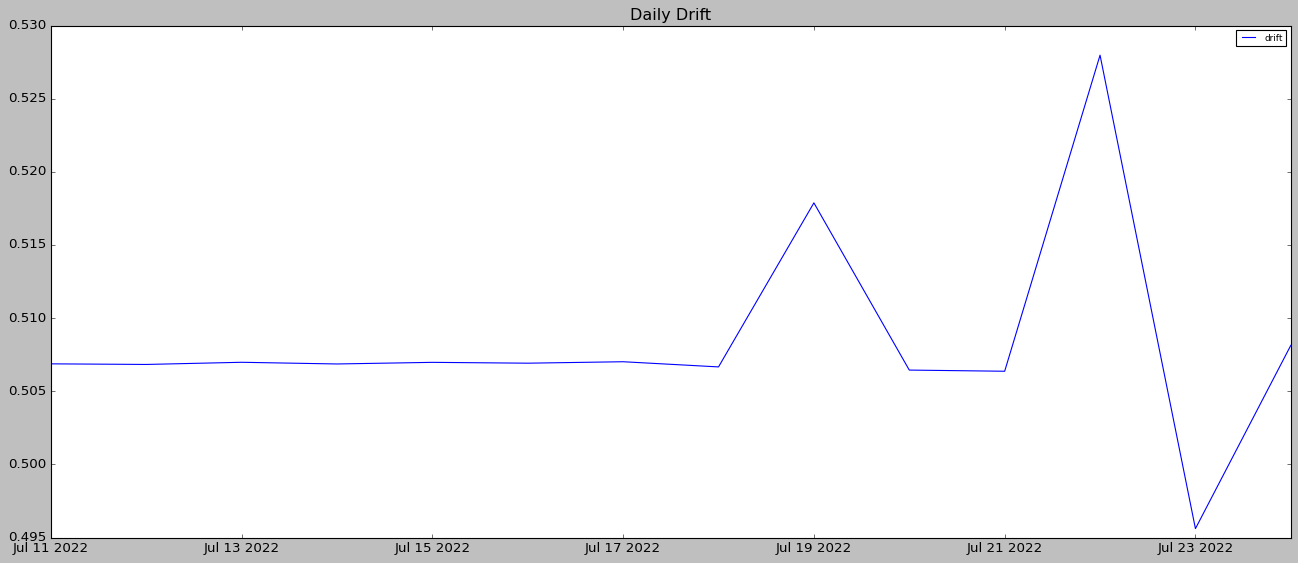

In [79]:
# Step 4:  Plot the `embeddings_drift` as a line chart, with date on the X-axis and the computed metric on the Y-axis.
plt.style.use("classic")

fig = plt.figure()
fig.set_size_inches(20, 8)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.title("Daily Drift")
plt.plot(cls_testdates, embeddings_drift, color="blue", label="drift")
plt.legend(fontsize="8")


In [80]:
"""
[TO BE IMPLEMENTED]

It seems like there is some divergence in the distributions of embeddings between the reference and target set on some days.
Let's visualize with UMAP (https://umap-learn.readthedocs.io/en/latest/). Uniform Manifold Approximation and Projection (UMAP)
is a dimension reduction technique that can be used for visualisation similarly to t-SNE.

1. We will train a UMAP model to project our original embedding space into 2 dimensions, using our reference (training) dataset.
2. We will then use this trained model to map the reference and the target dataset into two dimensions, and visualize it as a scatter plot.

Do this exercise separately for two target distributions:
1. inference traffic from 2022/07/11 (no drift)
2. inference traffic from 2022/07/24 (maximum drift)
"""

def train_umap_model(emb):
    umap_model = umap.UMAP(n_components=2)
    umap_model.fit(emb)
    return umap_model


umap_model = train_umap_model(embeddings_ref)
umap_ref = umap_model.transform(embeddings_ref)

# Similarly, use the umap_model.transform(...) function to compute 2d representations of inference traffic
umap_target_0711 = umap_model.transform(get_embedding_target_todate(LOG_DATE_START))
umap_target_0724 = umap_model.transform(get_embedding_target_todate(LOG_DATE_END))




/Users/sjabbireddy/.pyenv/versions/3.10.0/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [81]:
import plotly.express as px

final_df = []
for idx, ut in enumerate(umap_ref[:5000]):
    final_df.append([ut[0], ut[1], 'reference'])

for idx, ut in enumerate(umap_target_0711):
    final_df.append([ut[0], ut[1], 'target_2022-07-11'])

df = pd.DataFrame(
    final_df, columns=["x", "y", "label"]
)

fig = px.scatter(df, x="x", y="y", color="label")
fig.update_traces(marker={'size': 3})
fig.show()


In [82]:
import plotly.express as px

final_df = []
for idx, ut in enumerate(umap_ref[:5000]):
    final_df.append([ut[0], ut[1], 'reference'])

for idx, ut in enumerate(umap_target_0724):
    final_df.append([ut[0], ut[1], 'target_2022-07-24'])

df = pd.DataFrame(
    final_df, columns=["x", "y", "label"]
)

fig = px.scatter(df, x="x", y="y", color="label")
fig.update_traces(marker={'size': 3})
fig.show()


## Step 5: Model performance

Ground truth observations (true labels) are a critical part of all supervised/self-supervised machine learning. Ground truth is important not just for model training, but also for monitoring and measuring performance of models after deployment.

`annotations.json` is the set of ground truth labels for requests received by our online prediction service. Imagine we have a team of human annotators that label a fraction of our inference stream (with some delay). Eventually these ground truth labels are logged and will be helpful for us to monitor online model performance.


In [85]:
"""
[TO BE IMPLEMENTED]

Weekly classification report

Compute the a classification report for each week of the logged inference data
   Week 1 = [2022-07-11 and 2022-07-17]
   Week 2 = [2022-07-18 and 2022-07-24]

Do you notice a trend in model performance?
How does this correlate to observed drift in news source, embeddings etc ?
"""

from sklearn import metrics as sklearn_metrics

print("Dates: 2022/07/11 to 2022/07/17")
week1_report = df_logs_true_labels[df_logs_true_labels['date'] <= pd.to_datetime(date(2022, 7, 17))]
print(sklearn_metrics.classification_report(week1_report["label"], week1_report["pred_label"]))

print("Dates: 2022/07/18 to 2022/07/24")
week2_report = df_logs_true_labels[df_logs_true_labels['date'] > pd.to_datetime(date(2022, 7, 17))]
print(sklearn_metrics.classification_report(week2_report["label"], week2_report["pred_label"]))


Dates: 2022/07/11 to 2022/07/17
                           precision    recall  f1-score   support

                 Business       0.67      0.85      0.75      8138
            Entertainment       0.69      0.52      0.60     12914
                   Health       0.64      0.71      0.67      3171
              Music Feeds       0.98      0.78      0.87       204
                 Sci/Tech       0.65      0.63      0.64      7159
Software and Developement       0.52      0.05      0.09       655
                   Sports       0.80      0.92      0.86      9437
                    Toons       1.00      1.00      1.00       322

                 accuracy                           0.71     42000
                macro avg       0.74      0.68      0.68     42000
             weighted avg       0.70      0.71      0.69     42000

Dates: 2022/07/18 to 2022/07/24
                           precision    recall  f1-score   support

                 Business       0.37      0.85      0.51     

date
2022-07-11    0.791500
2022-07-12    0.790000
2022-07-13    0.786833
2022-07-14    0.728000
2022-07-15    0.659333
2022-07-16    0.591167
2022-07-17    0.593667
2022-07-18    0.485231
2022-07-19    0.488000
2022-07-20    0.457571
2022-07-21    0.392000
2022-07-22    0.337143
2022-07-23    0.346714
2022-07-24    0.378590
dtype: float64


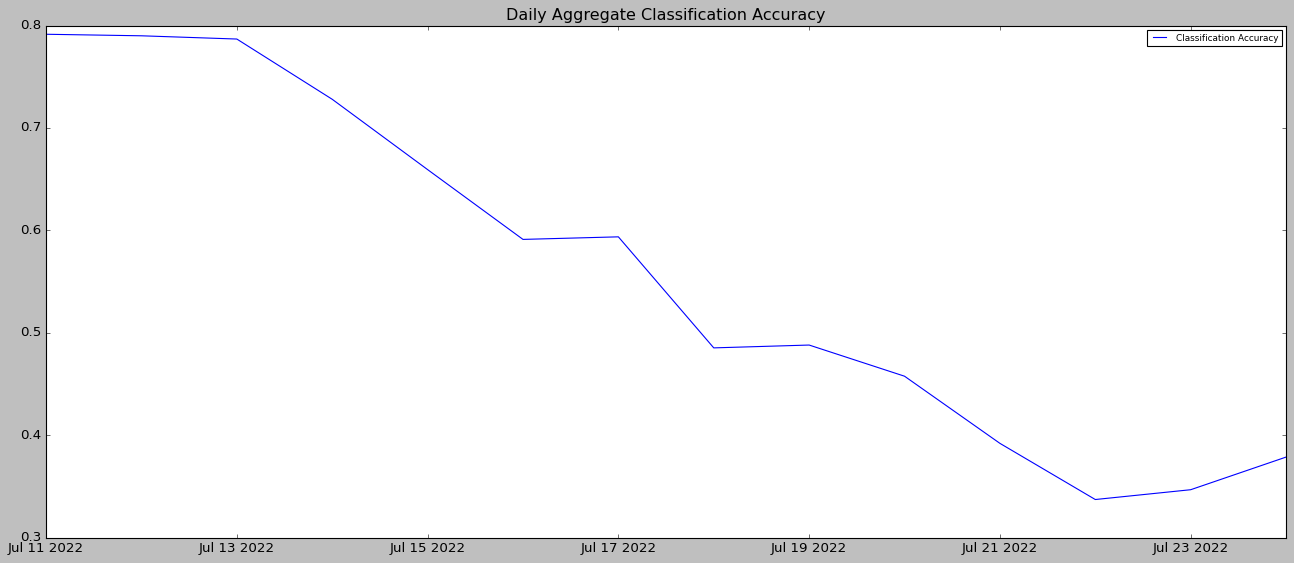

In [86]:

"""
[TO BE IMPLEMENTED]

Daily aggregate classification accuracy

1. Compute the daily aggregate classification accuracy of the model
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

Do you notice a trend in model performance?
How does this correlate to observed drift in news source, embeddings etc ?
"""
def accuracy_calc(df):
  accuracy = len(df[df["pred_label"] == df["label"]].values.tolist()) / len(df.values.tolist())
  return accuracy

accuracies_by_date = df_logs_true_labels.groupby("date").apply(accuracy_calc)

print(accuracies_by_date)

plt.style.use("classic")

fig = plt.figure()
fig.set_size_inches(20, 8)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.title("Daily Aggregate Classification Accuracy")
plt.plot(accuracies_by_date, color="blue", label="Classification Accuracy")
plt.legend(fontsize="8")


In [ ]:
"""
[TO BE IMPLEMENTED]

Daily classification accuracy, grouped by label

1. Compute the daily classification accuracy of the model, grouped by the true label category
2. Plot each of these as a line chart, with date on the X-axis and the computed metric on the Y-axis.
   You can plot them on the same chart, with different colors for each label

Do you notice a trend in model performance?
Are there labels that degrade more quickly or less quickly?
Are there labels that consistently perform worse?
"""
accuracies_by_date_and_true_label = df_logs_true_labels.groupby(["label", "date"]).apply(accuracy_calc)

print(accuracies_by_date_and_true_label)

In [131]:
accuracies_by_date_and_true_label_df = accuracies_by_date_and_true_label.unstack()
accuracies_by_date_and_true_label_df = accuracies_by_date_and_true_label_df.reset_index(level=[0])
df_unpivoted = accuracies_by_date_and_true_label_df.melt(id_vars='label', var_name='date', value_name='accuracies')
df_unpivoted

,label,date,accuracies
0,Business,2022-07-11,0.837174
1,Entertainment,2022-07-11,0.658859
2,Health,2022-07-11,0.829374
3,Music Feeds,2022-07-11,0.869565
4,Sci/Tech,2022-07-11,0.729614
...,...,...,...
107,Music Feeds,2022-07-24,0.571429
108,Sci/Tech,2022-07-24,0.276699
109,Software and Developement,2022-07-24,0.011834
110,Sports,2022-07-24,0.739903


In [132]:
fig = px.line(df_unpivoted, x='date', y='accuracies',color='label' )
fig.show()

label     date      
Business  2022-07-11    0.837174
          2022-07-12    0.837121
          2022-07-13    0.844340
          2022-07-14    0.845649
          2022-07-15    0.866850
                          ...   
Toons     2022-07-20    1.000000
          2022-07-21    1.000000
          2022-07-22    1.000000
          2022-07-23    1.000000
          2022-07-24    1.000000
Length: 112, dtype: float64


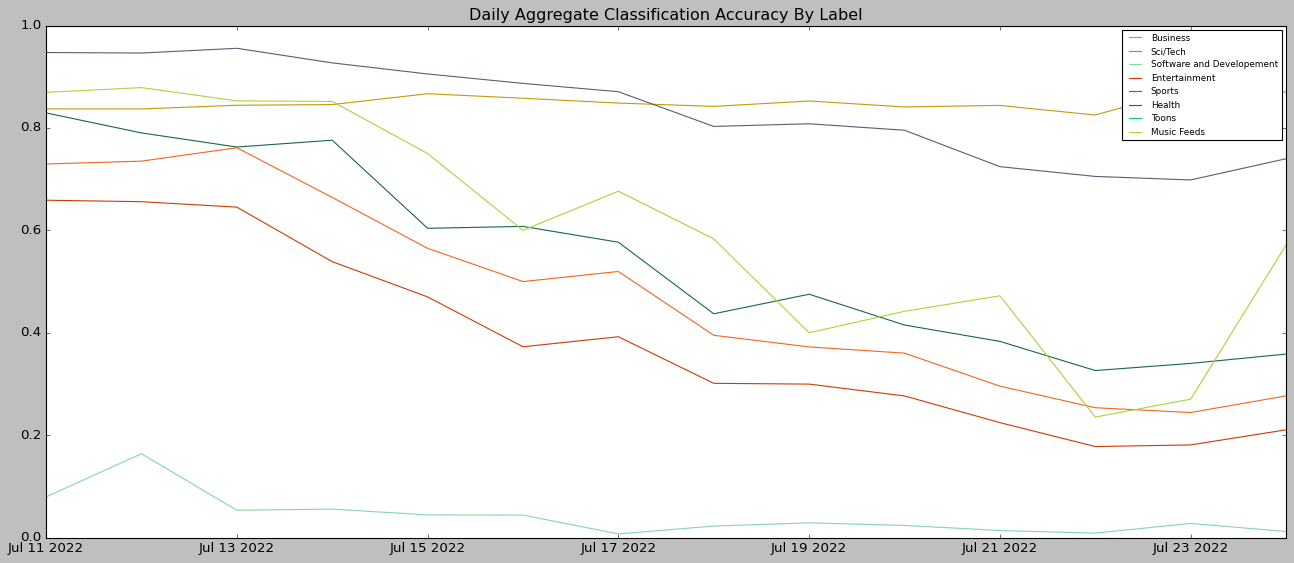

In [88]:


plt.style.use("classic")

fig = plt.figure()
fig.set_size_inches(20, 8)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.title("Daily Aggregate Classification Accuracy By Label")
colors = ['#C7980A', '#F4651F', '#82D8A7', '#CC3A05', '#575E76', '#156943', '#0BD055', '#ACD338']

for idx, label in enumerate(LABEL_SET):
  plt.plot(accuracies_by_date_and_true_label[label], color=colors[idx], label=label)
plt.legend(fontsize="8")




## [Optional] Step 6: Outliers & its impact on model performance

A common cause for ML model failures is outliers - data samples that are very different or “unlike” the rest of the samples, and hence unlikely to be seen by the model during training. Doing well on such outliers is especially critical for high stakes applications like self-driving cars and medical diagnostics

Unfortunately, it's not very easy to detect outliers because it's hard to constitute the criteria for an outlier. Typically, outlier detection algorithms fit (ex. via reconstruction) to the training set to understand what normal data looks like and then we can use a threshold to predict outliers.

Libraries such as [PyOD](https://pyod.readthedocs.io/en/latest/) and [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) are popular open source libraries for outlier detection.


In [167]:
from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

In [156]:
"""
[TO BE IMPLEMENTED]

Consider using libraries shared above to identify the most outlier examples
from the inference traffic, with respect to the training dataset.

Some approaches/architectures you might consider:
1. Local Outlier Factor or Isolation Forest (https://scikit-learn.org/stable/modules/outlier_detection.html)
2. Variational Auto encoder (https://github.com/yzhao062/pyod)
"""
news_sources_ref = [row['source'] for row in training]
news_sources_ref = list(filter(lambda l: l != "OTHER/UNKNOWN", news_sources_ref))
delta = LOG_DATE_END - LOG_DATE_START


In [159]:
training_df["label"].value_counts()

label
Entertainment                6815
Sports                       6167
Business                     5522
Sci/Tech                     4030
Health                       1865
Software and Developement     257
Toons                         225
Music Feeds                   119
Name: count, dtype: int64

In [158]:
out_training_df = training_df.query("source != 'OTHER/UNKNOWN'")
out_counts = out_training_df["source"].value_counts()
print(out_counts)

source
Reuters                         1033
Yahoo Sports                     734
Yahoo Entertainment              706
Reuters Business                 671
Forbes                           570
The Register                     414
San Francisco Chronicle          396
Yahoo Tech                       393
New York Times sports            390
New York Times                   343
Washington Post                  340
Bloomberg                        323
Reuters Sports                   301
The Washington Post sports       281
ABC News                         280
Yahoo Business                   266
Xinhua                           260
USA Today                        241
International Herald Tribune     238
Guardian                         231
The Motley Fool                  215
Yahoo Health                     205
Reuters Entertainment            195
Yahoo Science                    193
New York Times Business          189
The Scotsman                     186
Seattle Post Intelligencer     

In [143]:
training_df

,id,source,title,url,rank,description,embedding,label
0,86273,Voice of America,Capsule from Genesis Space Probe Crashes in Ut...,http://www.sciencedaily.com/releases/2004/09/0...,5,A capsule carrying solar material from the Gen...,"[0.014944990165531635, -0.012602416798472404, ...",Entertainment
1,488548,OTHER/UNKNOWN,Tunes Music Store Downloads Top 200 Million So...,http://www.macnewsworld.com/story/Apple-Disabl...,5,Apple Computer Apple announced Thursday that m...,"[0.016263173893094063, 0.05981703847646713, -0...",Sci/Tech
2,227379,Yahoo Tech,China Offers Rewards for Reporting Porn (AP),http://us.rd.yahoo.com/dailynews/rss/tech/*htt...,5,AP - China's police ministry on Sunday handed ...,"[0.051430340856313705, 0.014167562127113342, -...",Sci/Tech
3,146915,OTHER/UNKNOWN,Time for Euros to have fun in majors,http://www.indystar.com/articles/3/180376-2383...,5,So enough about why the United States can #39;...,"[-0.021981434896588326, 0.025182634592056274, ...",Sports
4,205960,OTHER/UNKNOWN,Lawyer: US wrecking life of man searched in an...,http://seattlepi.nwsource.com/national/apus_st...,5,"TOMS RIVER, NJ A lawyer for Doctor Kenneth Ber...","[0.020410768687725067, 0.1163247674703598, 0.0...",Health
...,...,...,...,...,...,...,...,...
24995,79466,OTHER/UNKNOWN,Turkish government: Hostage freed,http://www.ctv.ca/servlet/ArticleNews/story/CT...,5,Turkish Foreign Minister Abdullah Gul reported...,"[0.014458844438195229, 0.01171039417386055, 0....",Entertainment
24996,105592,The Register,Virus writers add network sniffer to worm,http://www.theregister.co.uk/2004/09/14/networ...,5,Virus writers have grafted a network sniffer i...,"[0.014189074747264385, -0.008578748442232609, ...",Sci/Tech
24997,100425,Washington Post,"In New York, Olympics Can Be Spelled JETS",http://www.eurosport.com/home/pages/V4/L0/S6/E...,5,New York will be forced to abandon its bid to ...,"[-0.04604348540306091, 0.08192720264196396, 0....",Sports
24998,149996,Guardian,Study finds dogs can smell cancer,http://www.newscientist.com/news/news.jsp?id=n...,5,"Dogs can sniff out cancer, a study shows today...","[0.05253065750002861, 0.046797558665275574, -0...",Entertainment


In [160]:
from sklearn.model_selection import train_test_split
# Get the target column
target_column = training_df["label"]

# Split the DataFrame into training and test sets, stratified by the target column
out_training_df,out_test_df = train_test_split(training_df, test_size=0.25, stratify=target_column, random_state=42)


In [161]:
"""
[TO BE IMPLEMENTED]

Measure the model performance (model accuracy) on the subset of data that is identified as outliers.

1. Compute the daily aggregate classification accuracy of the model on the subset of data that is identified as outliers.
2. Plot this metric as a line chart, with date on the X-axis and the computed metric on the Y-axis.

How does the model's performance on outliers compare to that on the inliers?
Do you see model performance is lower for outliers?
"""
from alibi_detect.od import IForest

od = IForest(
    threshold=0.,
    n_estimators=100
)

od.fit(
    np.array(out_training_df.embedding.tolist(), dtype=object)
)


In [163]:
od.infer_threshold(
    np.array(training_df.embedding.tolist(), dtype=object),
    threshold_perc=95
)

In [172]:
preds = od.predict(
    np.array(out_test_df.embedding.tolist(), dtype=object),
    return_instance_score=True
)

In [173]:
preds

{'data': {'instance_score': array([-0.06911218, -0.07415053, -0.05386875, ..., -0.0506622 ,
         -0.07910453, -0.06378221]),
  'feature_score': None,
  'is_outlier': array([0, 0, 0, ..., 0, 0, 0])},
 'meta': {'name': 'IForest',
  'online': False,
  'data_type': 'tabular',
  'version': '0.11.3',
  'detector_type': 'outlier'}}

In [176]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

labels = training_df.label
y_pred = preds['data']['is_outlier']
f1 = f1_score(out_test_df, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(out_test_df, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

TypeError: '<' not supported between instances of 'str' and 'int'

In [180]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [171]:
threshold_batch = create_outlier_batch(np.array(training_df.embedding.tolist(), dtype=object), training_df.label, n_samples=10000, perc_outlier=5)

ValueError: a must be greater than 0 unless no samples are taken